<a href="https://colab.research.google.com/github/sairoy49/satelliteimagerecognisation/blob/main/satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=19U9KgKaqbl2NntvQfcQrPXYMNR3ZzxuL
!tar -xvf "./train-jpg.tar" -C "./"

In [ ]:
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import Image as Img
import tensorflow as tf
from sklearn.metrics import fbeta_score

### Dataset
---
The dataset that maps the image names with the respective tags (labels) is read and modified, so as to inlude each image's whole filepath in Colab notebook. Additionally, another column that includes the respective labels as list items is created. Using that column, we extracted the unique labels existing at the dataset, and plotted a respective image per label.

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?id=1MsAf8Iktmf1dC1pYQpJ-QjC3lOAg5J_3&export=download')
df.head(10)

image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road

In [ ]:
df['image_name'] = './train-jpg/' + df['image_name'] + '.jpg'

df['tags_split'] = df['tags'].apply(lambda x: x.split(' '))
labels_list = sum(list(df['tags_split'].values), [])
labels = set(labels_list)
labels

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

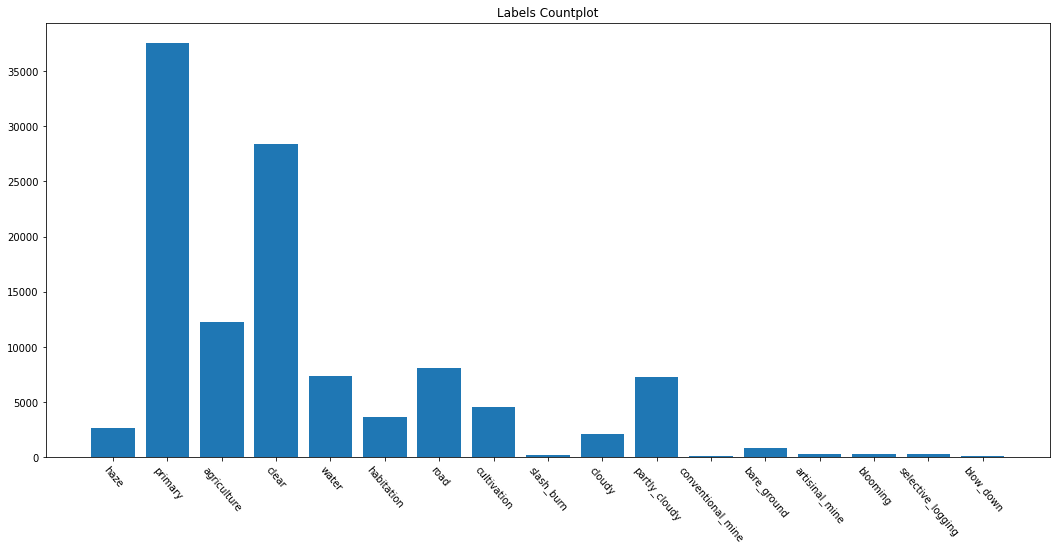

In [ ]:
cnt_label = {}
for label_names in df['tags_split'].values:
  for l in label_names:
    cnt_label[l] = cnt_label[l] + 1 if l in cnt_label else 0

plt.figure(figsize=(18,8))
idxs = range(len(cnt_label.values()))
plt.bar(idxs, cnt_label.values())
plt.xticks(idxs, cnt_label.keys(), rotation=-50)
plt.title('Labels Countplot')
plt.show()

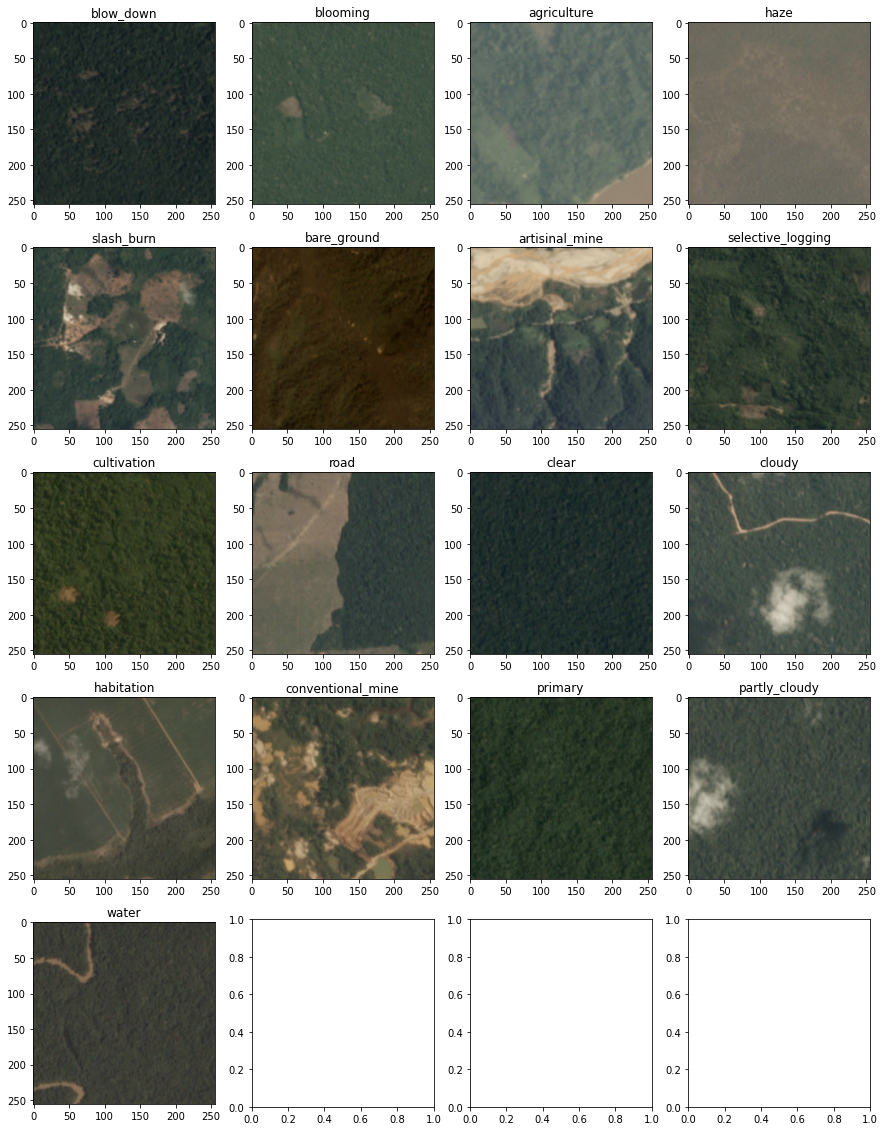

In [ ]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] for i, label in enumerate(labels)]

_, ax = plt.subplots(5,4, figsize=(15,20))
ax = ax.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
  img = mpimg.imread(image_name)
  ax[i].imshow(img)
  ax[i].set_title('{}'.format(label))

Details on the labels are present at [Chip (Image) Data Format](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) section in Kaggle.

In [ ]:
image_path_to_label = collections.defaultdict(list)
for image_path, label in zip(df['image_name'],df['tags'].values):
  image_path_to_label[image_path].append(f"<start> {label} <end>")

In [ ]:
image_paths = list(image_path_to_label.keys())
train_labels = []
img_name_vector = []

for image_path in image_paths:
  label_list = image_path_to_label[image_path]
  train_labels.extend(label_list)
  img_name_vector.extend([image_path]*len(label_list))

print(len(img_name_vector))

40479


In [ ]:
def load_image(image_path):
    """
    Input: Image path
    Output: Procesed image tensor, Image path
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))


  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 2530/2530 [07:05<00:00,  5.95it/s]


In [ ]:
def calc_max_length(tensor):
  """
  Calculate max length of any labelset in the dataset
  """
  return max(len(t) for t in tensor)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(set(train_labels)),
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~')
tokenizer.fit_on_texts(train_labels)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_sequences = tokenizer.texts_to_sequences(train_labels)

In [ ]:
tokenizer.word_index

{'<end>': 2,
 '<pad>': 0,
 '<start>': 1,
 'agriculture': 5,
 'artisinal_mine': 15,
 'bare_ground': 13,
 'blooming': 16,
 'blow_down': 18,
 'clear': 4,
 'cloudy': 12,
 'conventional_mine': 19,
 'cultivation': 9,
 'habitation': 10,
 'haze': 11,
 'partly_cloudy': 8,
 'primary': 3,
 'road': 6,
 'selective_logging': 14,
 'slash_burn': 17,
 'water': 7}

In [ ]:
# Pad each vector to the max_length of the labels
label_vector = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post')
print('Labels vector:\n', label_vector)

Labels vector:
 [[ 1 11  3 ...  0  0  0]
 [ 1  5  4 ...  0  0  0]
 [ 1  4  3 ...  0  0  0]
 ...
 [ 1  5  4 ...  0  0  0]
 [ 1  5  4 ...  0  0  0]
 [ 1  5  9 ...  0  0  0]]


In [ ]:
max_length = calc_max_length(train_sequences)
print('Max sequence length: ',max_length)

Max sequence length:  11


In [ ]:
img_to_label_vector = collections.defaultdict(list)

for image, label in zip(img_name_vector, label_vector):
  img_to_label_vector[image].append(label)

img_keys = list(img_to_label_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) *  0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
label_train = []

for imgt in img_name_train_keys:
  label_len = len(img_to_label_vector[imgt])
  img_name_train.extend([imgt] * label_len)
  label_train.extend(img_to_label_vector[imgt])

img_name_val = []
label_val = []

for imgt in img_name_val_keys:
  label_len = len(img_to_label_vector[imgt])
  img_name_val.extend([imgt] * label_len)
  label_val.extend(img_to_label_vector[imgt])

In [ ]:
# Print the respective training and validation lengths
len(img_name_train), len(label_train), len(img_name_val), len(label_val)

(32383, 32383, 8096, 8096)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size =  len(set(train_labels)) + 1
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
# These two variables represent the feature vector shape
features_shape = 2048
attention_features_shape = 49

In [ ]:
def map_func(img_name, label):
  """
  Load previously stored numpy files
  """
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, label_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
val_set = tf.data.Dataset.from_tensor_slices((img_name_val, label_val))

# Use map to load the numpy files in parallel
val_set = val_set.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Batch only
val_set = val_set.batch(BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# Initialize encoder and decoder networks

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

#SP: for calculating accuracy during training
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# Create checkpoint to store trained model parameters for future use
checkpoint_path = "./checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# List to keep the recorded training loss
train_loss_plot = []
val_loss_plot = []

Summary of the encoder - decoder architecture

In [ ]:
encoder.summary()

Model: "cnn__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  115200    
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  230850    
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 2,579,395
Trainable params: 2,579,395
Non-trainable params: 0
_________________________________________________________________


### Evaluation procedure
---
The model is reset to the state where validation loss had the lowest value.

The average F-beta score is calculated within the validation dataset.

In [ ]:
def test(image):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    flag = False

    for i in range(max_length-1):
        if not flag:
          predictions, hidden, _ = decoder(dec_input,features, hidden)


          predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
          #result.append(tokenizer.index_word[predicted_id])
          result.append(predicted_id)

          if tokenizer.index_word[predicted_id] == '<end>':
              flag = True
        else:
          result.append(0)

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
def evaluation_score():
  score = 0
  for id in range(0, len(img_name_val)-1):
    image = img_name_val[id]
    real_caption = [i for i in label_val[id] if i != 1]
    real = np.sum(tf.one_hot(real_caption, len(tokenizer.word_index)).numpy(), axis=0)

    result = test(image)
    predicted = np.sum(tf.one_hot(result,len(tokenizer.word_index)).numpy(), axis=0)

    f = fbeta_score(real, predicted, average='weighted', beta=1)

    score += f/len(img_name_val)

  return score

In [ ]:
score = evaluation_score()
print('Average F-beta score at validation dataset: ', score)

Average F-beta score at validation dataset:  0.8391796237252559


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    image = Image.open(image)

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
def test_image(img_id):
  # Labels on the validation set
  image = img_name_val[img_id]
  real_caption = ' '.join([tokenizer.index_word[i] for i in label_val[img_id] if i not in [0]])
  result, attention_plot = evaluate(image)

  actual_image = Image.open(image)
  plt.imshow(actual_image)

  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)

In [ ]:
# Restore networks at their latest saved state
ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
!zip -r './checkpoints.zip' './checkpoints'

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/checkpoint (deflated 71%)
  adding: checkpoints/ckpt-7.index (deflated 69%)
  adding: checkpoints/ckpt-8.data-00000-of-00001 (deflated 38%)
  adding: checkpoints/ckpt-10.data-00000-of-00001 (deflated 39%)
  adding: checkpoints/ckpt-8.index (deflated 69%)
  adding: checkpoints/ckpt-9.index (deflated 69%)
  adding: checkpoints/ckpt-10.index (deflated 69%)
  adding: checkpoints/ckpt-7.data-00000-of-00001 (deflated 37%)
  adding: checkpoints/ckpt-11.index (deflated 69%)
  adding: checkpoints/ckpt-11.data-00000-of-00001 (deflated 39%)
  adding: checkpoints/ckpt-9.data-00000-of-00001 (deflated 39%)


Evaluating the performance on 8 chip images from the validation dataset

Real Caption: <start> clear primary water <end>
Prediction Caption: clear primary <end>


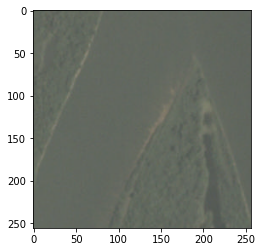

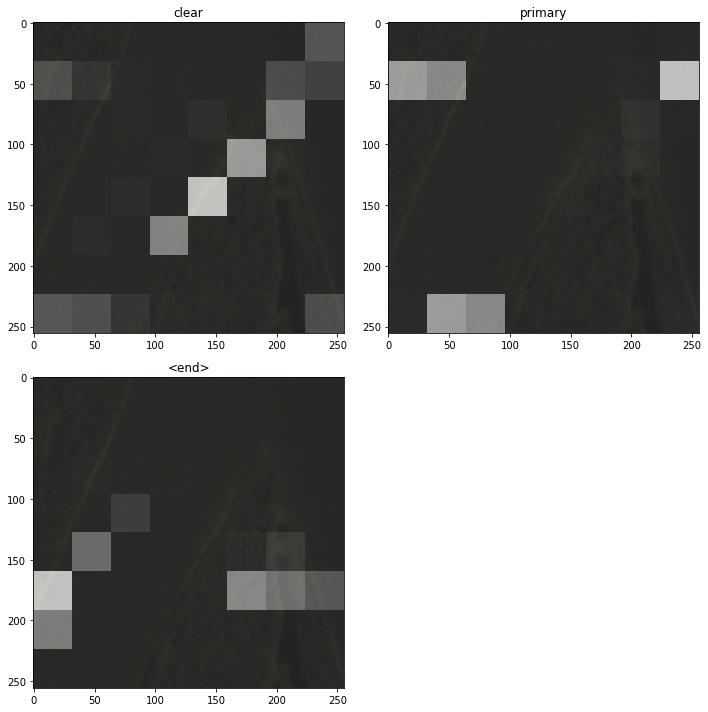

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> agriculture clear primary <end>
Prediction Caption: agriculture clear cultivation primary <end>


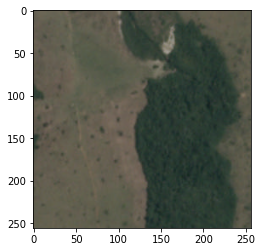

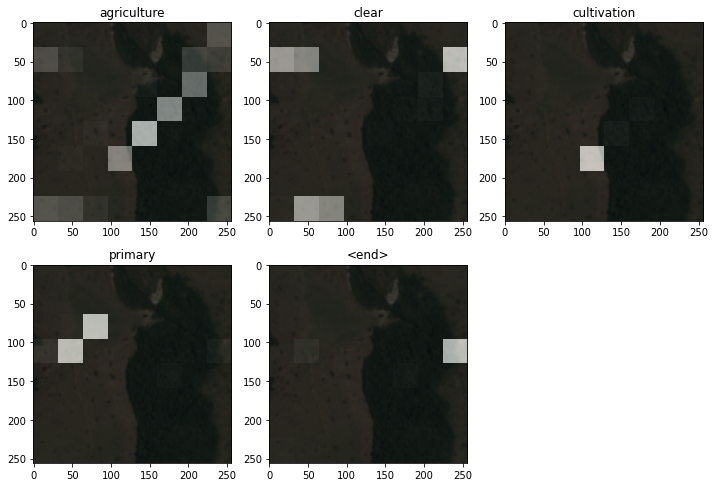

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: agriculture clear habitation primary road water <end>


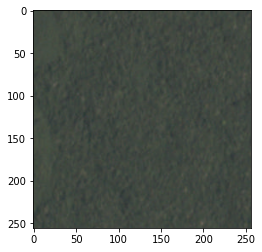

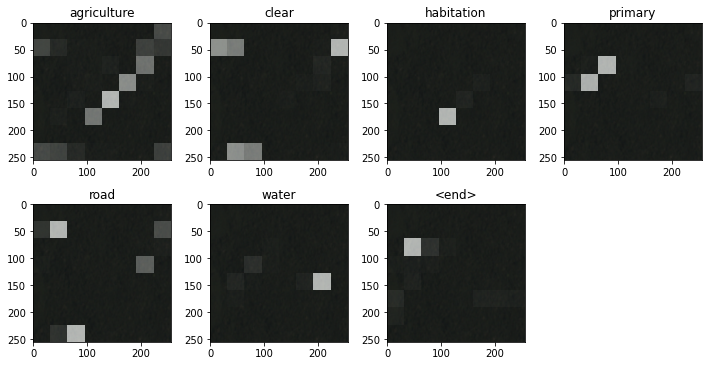

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: partly_cloudy primary water <end>


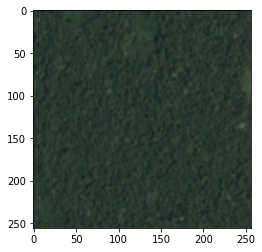

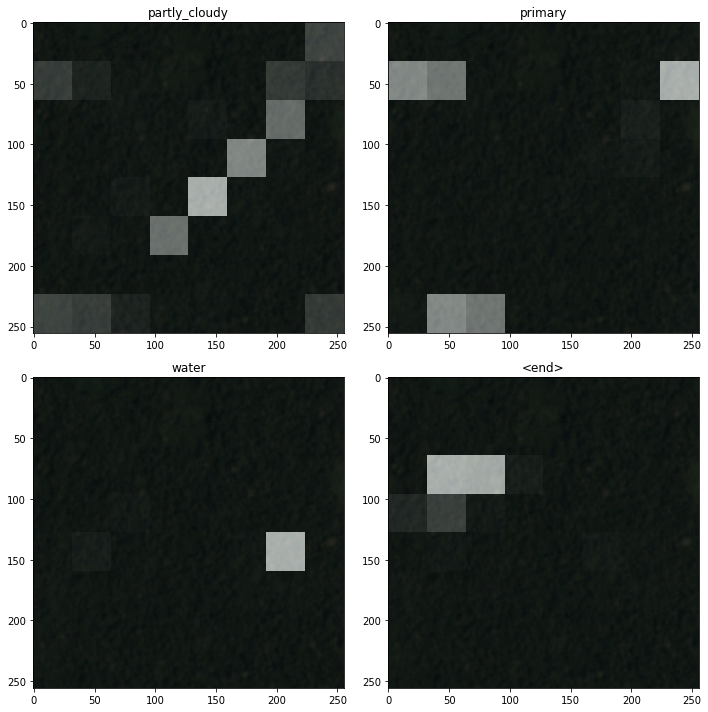

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: haze primary water <end>


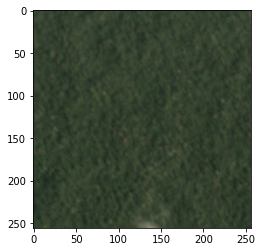

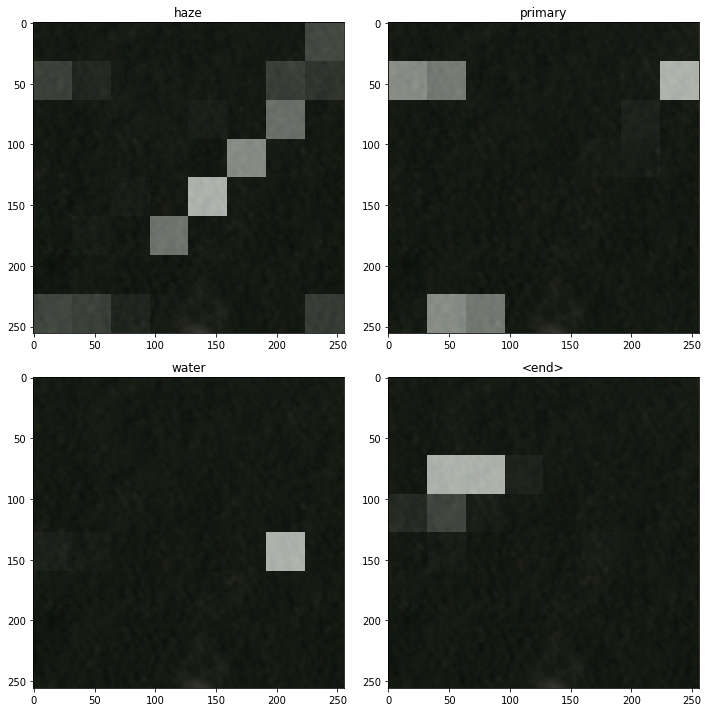

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: agriculture clear primary road <end>


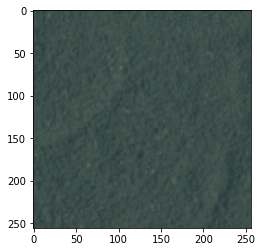

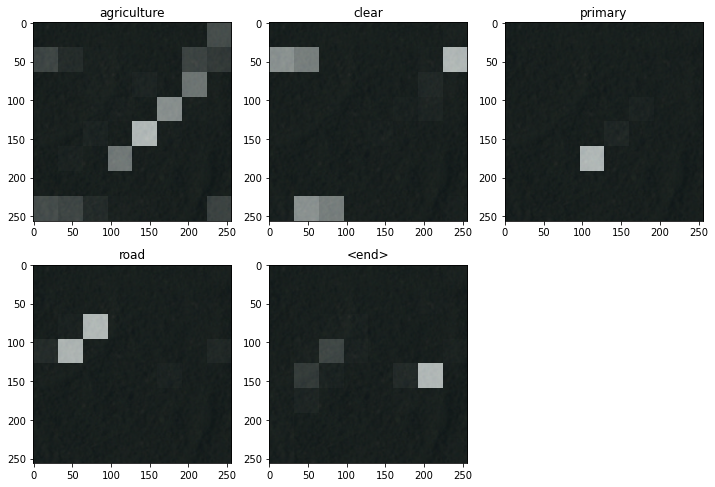

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: clear primary <end>


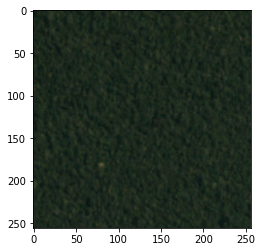

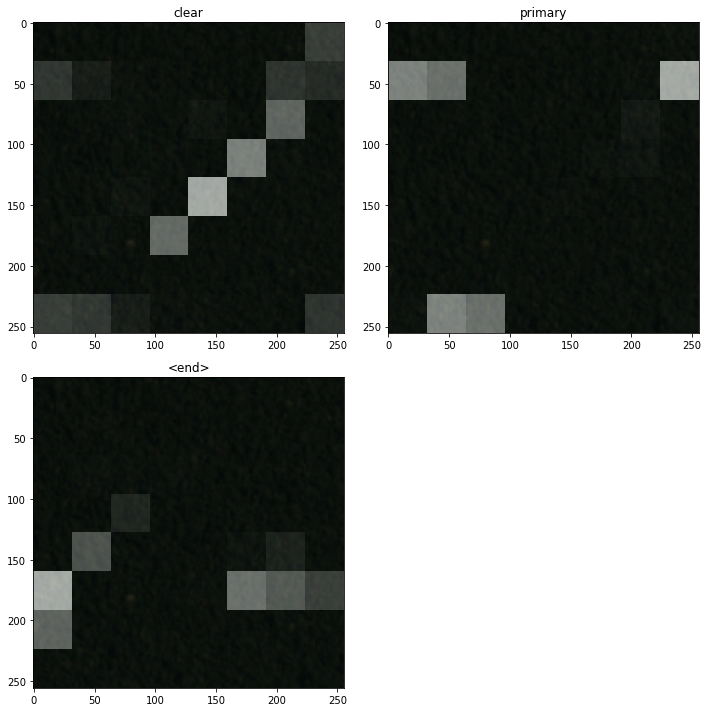

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

Real Caption: <start> clear primary <end>
Prediction Caption: partly_cloudy primary water <end>


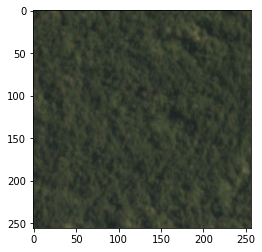

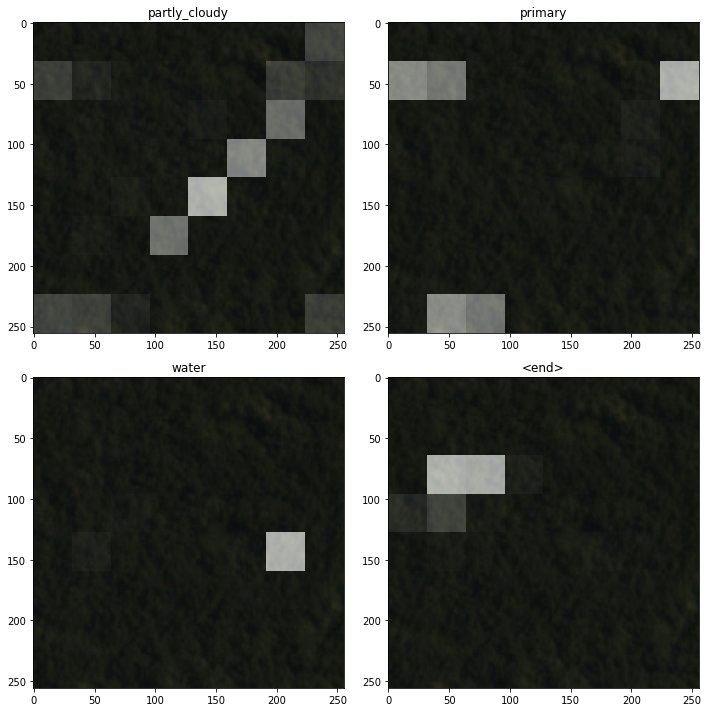

In [ ]:
id = np.random.randint(0, len(img_name_val))
test_image(id)

### Conclusions
---
Satellite image classification using attention mechanism at the encoder - decoder schema is a feasible approach. The model achieved F-beta score greater than 83%. The highest F-beta score from the respective Kaggle competition leaderboard was around 93%.

Our approach utilizes the JPG version of the satellite images dataset and not the original TIF version. An approach that utilizes the TIF version would probably provide better results, however it would be resource demanding, outside of the purposes of this project.

We used the ResNet pretrained at the ImageNet dataset, as feature extractor. Probably, fine-tuning the model to the satellite image dataset, by using Transfer Learning methods, before proceeding with the feature extraction would provide better results.

Model training took place inside a GPU enabled Colab notebook. Limitations at resources, mainly at GPU usage did not allow us make extensive experiments.

Future improvements include selecting a different pre-trained network as feature extractor, modifying model architecture by replacing the GRU layer with an LSTM one and/or selecting a different attention mechanism.